In [7]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import logging, os, glob
from _logging import set_logging
from _metrics import display_metrics
from _pckle import save_pickle_object, load_pickle_object
from _utility import gl, get_perc, get_dictionaries_from_list
from _model import train_model
from _graph import accuracy_loss_graph

set_logging(logging)
logging.info(f"Cuda is available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ["Business", "Other"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)


2023-02-07 13:00:29,559 | INFO : Cuda is available: True


In [8]:
train_loader = load_pickle_object(gl.pkl_train_loader)
val_loader = load_pickle_object(gl.pkl_val_loader)

2023-02-07 13:00:30,264 | INFO : Loading pickle file from: pickle\pkle_train_loader.pkl
2023-02-07 13:00:31,219 | INFO : Loading pickle file from: pickle\pkle_val_loader.pkl


In [9]:
dataloaders = {"train": train_loader, "val": val_loader}
train_dataset_size = len(train_loader.dataset)
val_dataset_size = len(val_loader.dataset)
dataset_sizes = {"train": train_dataset_size, "val": val_dataset_size}
logging.info(f"Train dataset size: {train_dataset_size}")
logging.info(f"Val dataset size: {val_dataset_size}")
# Get the latest version of the Resnet weights and freeze the layers
model_conv = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Only parameters of final layer are being optimized
optimizer_ft = optim.Adam(model_conv.fc.parameters(), lr=0.0001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

2023-02-07 13:00:31,357 | INFO : Train dataset size: 35046
2023-02-07 13:00:31,358 | INFO : Val dataset size: 8762


## Set up Checkpoint and Early Stopping

In [10]:
if os.path.exists(gl.chk_dir) == False:
    os.mkdir(gl.chk_dir)
    
checkpoint_path = os.path.join(gl.chk_dir, gl.chk_resnet_model)

In [11]:
def load_checkpoint(checkpoint_path, model_conv, optimizer_ft):
    checkpoint = torch.load(checkpoint_path)
    model_conv.load_state_dict(checkpoint["model_state_dict"])
    optimizer_ft.load_state_dict(checkpoint["model_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return checkpoint, model_conv, optimizer_ft, epoch, loss

In [12]:
load_checkpoint_flag = False
if load_checkpoint_flag:
    checkpoint, model_conv, optimizer_ft, epoch, loss = \
        load_checkpoint(checkpoint_path, model_conv, optimizer_ft)
    
patience = 2
model_conv, epoch_train_accuracy, epoch_train_losses, epoch_val_accuracy, epoch_val_losses = \
    train_model(model_conv, logging, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, 
                         checkpoint_path, patience, num_epochs=25)

save_pickle_object(model_conv, gl.pkl_model_conv)


2023-02-07 13:00:35,440 | INFO : Epoch 1/25
2023-02-07 13:00:35,443 | INFO : ----------
2023-02-07 13:52:05,828 | INFO : train Loss: 0.5830 Acc: 0.6839
2023-02-07 14:03:19,195 | INFO : val Loss: 0.5226 Acc: 0.7401
Best validation accuracy: 0.7401278246975577
Saving best model for epoch: 1
2023-02-07 14:03:20,765 | INFO : Epoch 2/25
2023-02-07 14:03:20,765 | INFO : ----------
2023-02-07 14:59:30,983 | INFO : train Loss: 0.5105 Acc: 0.7531
2023-02-07 15:12:14,122 | INFO : val Loss: 0.4906 Acc: 0.7602
Best validation accuracy: 0.7602145628851861
Saving best model for epoch: 2
2023-02-07 15:12:18,455 | INFO : Epoch 3/25
2023-02-07 15:12:18,457 | INFO : ----------
2023-02-07 16:04:25,485 | INFO : train Loss: 0.4943 Acc: 0.7622
2023-02-07 16:15:49,450 | INFO : val Loss: 0.4829 Acc: 0.7685
Best validation accuracy: 0.7685459940652819
Saving best model for epoch: 3
2023-02-07 16:15:50,490 | INFO : Epoch 4/25
2023-02-07 16:15:50,491 | INFO : ----------
2023-02-07 16:58:45,789 | INFO : train Los

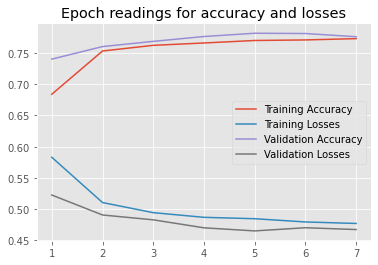

In [13]:

accuracy_loss_graph(epoch_train_accuracy, epoch_train_losses, epoch_val_accuracy, epoch_val_losses)

The training and validation statistics are close to each other which shows that there is no overfitting.<br>
The best results for the model training occured on the 5th epoch, so will we use this model in s5_TwitterProject.ipynb to test how good this model is.